<a href="https://colab.research.google.com/github/alexweltgeist/automarken_cnn/blob/main/Autobilder_2ter_Versuch_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automarken aufgrund von Bildern erkennen**

Versuch die Daten ins Colab zu laden um von der GPU zu profitieren. Das Daten laden wurde über verschiedene Wege probiert, allerdings ist entweder das Daten kopieren sehr langsam oder (wenn nur verlinkt) die Bearbeitungszeit im Model-Training ist sehr sehr langsam. --> Keine gute Lösung auf Colab gefunden. Zum Schluss war die lokale Alternative die bessere Lösung. Siehe Autobilder_3tr_Versuch.ipynb

In [1]:
import os, shutil, glob, re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics as sk_metrics
import itertools
import matplotlib.pyplot as plt
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(phisical_devices[0], True)

Num GPUs Available:  1


## **Data ins Colab laden**

In [3]:
! ls

sample_data


In [ ]:
# Solution 1 for Dataload: load data manually from local system (i.e. zip file)
# takes very long --> not usefull for large datasets
'''
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
'''
# then move the uploaded file into the right folder
'''!mv testdata.zip Dataset'''

# then expand files and folderstructure in the folder
'''from zipfile import ZipFile
file_name = 'Dataset/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('Dataset')
  print('Done')'''

In [ ]:
# Solution 2 for Dataload: work directly with mounted Google Drive
# load data to Google drive manually 
# very slow in the model training
'''train_path = 'drive/MyDrive/Dataset/train'
valid_path = 'drive/MyDrive/Dataset/valid'
test_path = 'drive/MyDrive/Dataset/test'
'''

In [10]:
# Code um allenfalls bestehende Verzeichnisse oder Files zu löschen
! rm ~/.kaggle/kaggle.json
! rm -rf sample_data
! rm testdata.zip
! rm -rf Dataset
! mkdir Dataset

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory
rm: cannot remove 'testdata.zip': No such file or directory


In [11]:
# Solution 2 for Dataload: copy data from drive to colab
# you need to mount the drive first (file section on the left)
# Beispieldaten - kleines Datenset mit ca 400 Bildern kopieren - braucht ca 3 min
!cp -r "/content/drive/MyDrive/beispiel/test" "/content/Dataset" 
!cp -r "/content/drive/MyDrive/beispiel/train" "/content/Dataset" 
!cp -r "/content/drive/MyDrive/beispiel/valid" "/content/Dataset"

In [5]:
# Real Data - copying takes ca 8 hours... (useless)
# using the command "!ln -s" (symbolic link) does also not help: is very slow in model training
!cp -r "/content/drive/MyDrive/Dataset/test" "/content/Dataset" 
!cp -r "/content/drive/MyDrive/Dataset/train" "/content/Dataset" 
!cp -r "/content/drive/MyDrive/Dataset/valid" "/content/Dataset"

In [12]:
train_path = '/content/Dataset/train'
valid_path = '/content/Dataset/valid'
test_path = '/content/Dataset/test'

In [13]:
all_subdirs = os.listdir(train_path)
len(all_subdirs)

3

## **Bilddaten preprocessen und anzeigen**

In [14]:
train_batches = ImageDataGenerator(rescale=1./255, 
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, 
                                                                                                                                            target_size=(224,224), 
                                                                                                                                            classes=all_subdirs, 
                                                                                                                                            batch_size=32)
valid_batches = ImageDataGenerator(rescale=1./255, 
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, 
                                                                                                                                            target_size=(224,224), 
                                                                                                                                            classes=all_subdirs, 
                                                                                                                                            batch_size=32)
test_batches = ImageDataGenerator(rescale=1./255, 
                                  preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, 
                                                                                                                                           target_size=(224,224), 
                                                                                                                                           classes=all_subdirs, 
                                                                                                                                           batch_size=32, 
                                                                                                                                           shuffle=False)

Found 246 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


In [15]:
imgs, labels = next(train_batches)
len(labels[0])

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

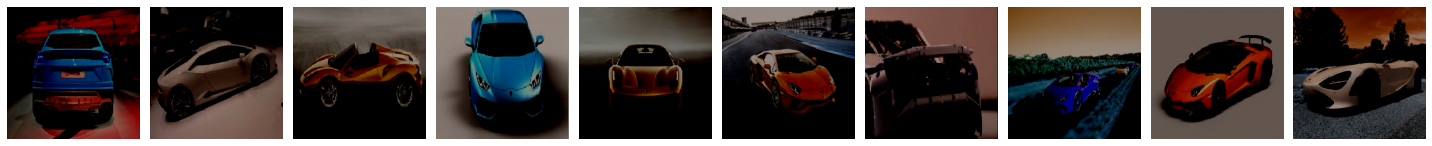

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [16]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = next(train_batches)
plot_images(imgs)
print(labels)

## **CNN Model aufbauen**

In [17]:
# Define hyperparameter of the CNN
batch_size = 32
nb_classes = len(labels[0])
img_rows, img_cols = 224, 224
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

In [18]:
nb_classes

3

In [19]:
# define CNN with 3 convolution blocks and 2 fully connected layers
# includes 1 MaxPooling layers and 1 Dropout layer
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))

model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

'''model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))

model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))'''

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# summarize model along with number of model weights
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       584       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0

## **Modell trainieren**

In [ ]:
# Create a callback that saves the model's weights
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [20]:
# train the model
history=model.fit(train_batches, 
                  batch_size=32, 
                  epochs=15,
                  verbose=1, 
                  validation_data=(valid_batches)
 #                 callbacks=[cp_callback]   # Pass callback to training
                  )  

Epoch 1/15
8/8 [==============================] - 34s 210ms/step - loss: 2.6467 - accuracy: 0.4691 - val_loss: 0.9110 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 1s 120ms/step - loss: 0.8133 - accuracy: 0.6407 - val_loss: 0.7160 - val_accuracy: 0.6463
Epoch 3/15
8/8 [==============================] - 1s 122ms/step - loss: 0.6573 - accuracy: 0.6612 - val_loss: 0.6412 - val_accuracy: 0.7073
Epoch 4/15
8/8 [==============================] - 1s 121ms/step - loss: 0.5909 - accuracy: 0.7811 - val_loss: 0.5747 - val_accuracy: 0.7561
Epoch 5/15
8/8 [==============================] - 1s 120ms/step - loss: 0.4484 - accuracy: 0.8493 - val_loss: 0.5072 - val_accuracy: 0.8415
Epoch 6/15
8/8 [==============================] - 1s 124ms/step - loss: 0.3420 - accuracy: 0.9069 - val_loss: 0.4900 - val_accuracy: 0.7561
Epoch 7/15
8/8 [==============================] - 1s 125ms/step - loss: 0.2420 - accuracy: 0.9088 - val_loss: 0.4083 - val_accuracy: 0.8659
Epoch 8/15
8/8 [===

In [ ]:
# Save the model
model.save('./checkpoints/saved_model')

INFO:tensorflow:Assets written to: ./checkpoints/saved_model/assets


## **Modell Evaluation**

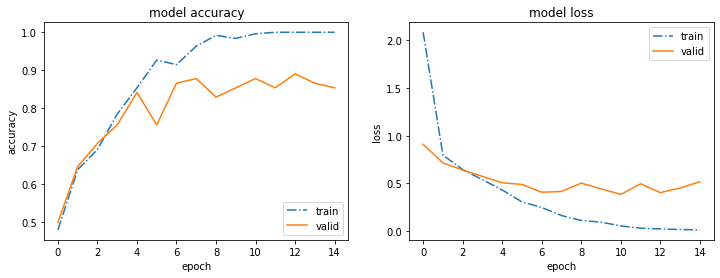

In [21]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [22]:
# Predict Brands on Test Data

pred=model.predict(test_batches)
y_pred = np.argmax(pred, axis=1)
print(all_subdirs)
print(confusion_matrix(test_batches.classes, y_pred))

['Ferrari', 'McLaren', 'Lamborghini']
[[15  0  3]
 [ 0  9  5]
 [ 2  1 47]]


In [23]:
target_names = all_subdirs
print(classification_report(test_batches.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Ferrari       0.88      0.83      0.86        18
     McLaren       0.90      0.64      0.75        14
 Lamborghini       0.85      0.94      0.90        50

    accuracy                           0.87        82
   macro avg       0.88      0.81      0.83        82
weighted avg       0.87      0.87      0.86        82



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Beispiele


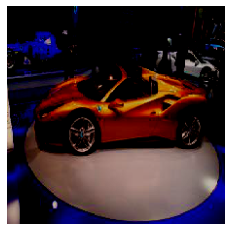

Richtiges label: Ferrari
Predicted label: Ferrari


In [24]:
def get_class_string_from_index(index):
   for class_string, class_index in test_batches.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_batches)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)

print("Beispiele")
plt.imshow(image * 1.3)
plt.axis('off')
plt.show()
print("Richtiges label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))